PROBLEM 7: DBSCAN on real data

Run the DBSCAN algorithm on:

1. 20NG

2. FASHION 

3. HouseHold (see papers), and evaluate results.

You need to implement both phases:
1) Neighborhoods creation

2) DBSCAN

Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

In [570]:
import sklearn
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

### FASHION DATASET:

In [571]:
data_fashion = torchvision.datasets.FashionMNIST(root='./fashion', download=True, transform=transforms.ToTensor())
print(data_fashion[0][0])

#truncate to 1000 samples:
data_fashion.data = data_fashion.data[:2000]
data_fashion.targets = data_fashion.targets[:2000]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [572]:
data_fashion_numpy = data_fashion.data.numpy()
print(data_fashion_numpy[0])
print(len(data_fashion_numpy[0]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [573]:

print(data_fashion.targets)
data_fashion_labels = data_fashion.targets.numpy()[:2000]
# print(data_fashion_labels)

tensor([9, 0, 0,  ..., 3, 5, 8])


In [574]:
# test euclidean distances between the two types (tensors and numpy arrays)
print("Between tensors: ", torch.dist(data_fashion[0][0], data_fashion[1][0]), "using norm: ", torch.norm(data_fashion[0][0] - data_fashion[1][0]), "using numpy: ", np.linalg.norm(data_fashion[0][0].numpy() - data_fashion[1][0].numpy()))
print("Between tensors: ", torch.dist(data_fashion[1][0], data_fashion[2][0]), "using norm: ", torch.norm(data_fashion[1][0] - data_fashion[2][0]), "using numpy: ", np.linalg.norm(data_fashion[1][0].numpy() - data_fashion[2][0].numpy()))
print("Between numpy arrays: ", np.linalg.norm(data_fashion_numpy[1][0] - data_fashion_numpy[2][0]))
print("Between numpy arrays: ", np.linalg.norm(data_fashion_numpy[0][0] - data_fashion_numpy[1][0]))

Between tensors:  tensor(14.6757) using norm:  tensor(14.6757) using numpy:  14.675714
Between tensors:  tensor(11.8889) using norm:  tensor(11.8889) using numpy:  11.888938
Between numpy arrays:  394.31839926637963
Between numpy arrays:  614.6169538826601


In [575]:
# 1. Compute distances, get neighbors:

def euclidean_distance(x, y):
    # Convert tensors to float type
    x = x.float()
    y = y.float()
    return torch.dist(x, y)

def get_neighbors(data, point, epsilon):
    neighbors = []
    # print("point: ", point)
    # print("data: ", data)
    # differing between samples:
    for i in range(len(data)):
        if euclidean_distance(data[i], point) < epsilon:
            neighbors.append(i)
    return neighbors

# 2. DBSCAN algorithm:
def dbscan(df, epsilon, min_points):
    labels = [0] * len(df)
    c = 0
    for i in tqdm(range(len(df))):
        if labels[i] != 0:
            continue
        neighbors = get_neighbors(df, df[i], epsilon)
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            new_neighbors = get_neighbors(df, df[j], epsilon)
            if len(new_neighbors) >= min_points:
                neighbors.extend(new_neighbors)
    return labels



In [576]:
# to find best epsilon:
neighbors = get_neighbors(data_fashion.data, data_fashion.data[1], 2100)
neighbors = sorted(neighbors)
print("neighbors: ", neighbors)
print(len(neighbors))
print("labels: ", data_fashion.targets[neighbors])

# print counts of neighbors
unique, counts = np.unique(data_fashion.targets[neighbors], return_counts=True)
print("unique: ", unique)
print("counts: ", counts)

neighbors:  [1, 10, 17, 48, 55, 66, 149, 154, 171, 176, 180, 191, 206, 219, 225, 237, 272, 304, 321, 329, 331, 338, 410, 415, 441, 448, 506, 519, 523, 524, 526, 549, 564, 565, 595, 640, 641, 665, 715, 716, 732, 741, 745, 748, 771, 780, 789, 812, 815, 816, 823, 825, 829, 839, 877, 880, 893, 905, 965, 967, 1013, 1041, 1056, 1073, 1078, 1084, 1103, 1119, 1142, 1158, 1169, 1228, 1264, 1287, 1288, 1303, 1311, 1327, 1329, 1410, 1424, 1460, 1516, 1526, 1585, 1599, 1600, 1603, 1608, 1622, 1647, 1682, 1731, 1737, 1745, 1790, 1791, 1800, 1837, 1843, 1846, 1849, 1850, 1861, 1897, 1912, 1929, 1942, 1950, 1956, 1979, 1989]
112
labels:  tensor([0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0,
        0, 0, 6, 0, 6, 0, 6, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 6, 0, 0, 0,
        0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 6,
        0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,

In [577]:
# to find best epsilon:
neighbors = get_neighbors(data_fashion.data, data_fashion.data[1], 2700)
neighbors = sorted(neighbors)
print("neighbors: ", neighbors)
print(len(neighbors))
print("labels: ", data_fashion.targets[neighbors])

# print counts of neighbors
unique, counts = np.unique(data_fashion.targets[neighbors], return_counts=True)
print("unique: ", unique)
print("counts: ", counts)

neighbors:  [1, 3, 5, 10, 17, 18, 20, 24, 25, 26, 32, 37, 40, 45, 47, 48, 49, 51, 55, 56, 57, 61, 65, 66, 72, 75, 77, 94, 95, 98, 112, 113, 140, 149, 151, 154, 157, 160, 164, 168, 171, 176, 180, 186, 187, 190, 191, 199, 203, 204, 206, 207, 219, 225, 231, 232, 234, 237, 240, 243, 245, 252, 253, 255, 261, 268, 269, 272, 287, 302, 304, 309, 314, 315, 318, 321, 323, 324, 329, 331, 332, 334, 336, 338, 344, 350, 354, 362, 368, 375, 377, 383, 387, 392, 395, 407, 410, 415, 422, 426, 433, 441, 444, 448, 480, 488, 489, 493, 495, 499, 500, 501, 504, 506, 508, 509, 519, 522, 523, 524, 526, 530, 536, 543, 549, 564, 565, 567, 568, 571, 574, 586, 590, 591, 592, 595, 600, 601, 609, 626, 640, 641, 645, 649, 662, 665, 670, 672, 673, 678, 684, 686, 687, 696, 701, 712, 715, 716, 720, 725, 731, 732, 733, 737, 741, 742, 745, 748, 755, 756, 766, 771, 780, 789, 797, 802, 808, 812, 815, 816, 823, 824, 825, 829, 830, 839, 855, 858, 863, 871, 875, 877, 880, 881, 882, 888, 893, 905, 906, 910, 911, 922, 923, 925, 

In [578]:
# count of 0 labels:
unique, counts = np.unique(data_fashion.targets, return_counts=True)
print("unique: ", unique)
print("counts: ", counts)

unique:  [0 1 2 3 4 5 6 7 8 9]
counts:  [194 216 202 195 186 200 194 215 198 200]


In [579]:
# example distance between two points of the same class
print(data_fashion_labels[:10])
print("Dist within a cluster: ", euclidean_distance(data_fashion.data[1], data_fashion.data[2]))
print(data_fashion.targets[1], data_fashion.targets[2])
print("Dist between two different clusters: ", euclidean_distance(data_fashion.data[0], data_fashion.data[8]))
print(data_fashion.targets[0], data_fashion.targets[8])

[9 0 0 3 0 2 7 2 5 5]
Dist within a cluster:  tensor(3031.6790)
tensor(0) tensor(0)
Dist between two different clusters:  tensor(3495.4448)
tensor(9) tensor(5)


In [598]:
# pass it: (aim for around 50 in the first cluster)
labels = dbscan(data_fashion.data, 1020, 3)

100%|██████████| 2000/2000 [01:28<00:00, 22.56it/s]


In [597]:
# 1050,5
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1}
Counts of clusters:  {1: 184, 2: 121, 3: 39, 4: 181, 5: 23, 6: 18, 7: 10, 8: 11, 9: 4, 10: 11, 11: 9, 12: 7, 13: 14, 14: 17, 15: 10, 16: 5, 17: 5, 18: 5, 19: 5, -1: 1321}


In [599]:
# afterwards to compare: 1020,3 
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, -1}
Counts of clusters:  {1: 275, 2: 49, 3: 53, 4: 173, 5: 18, 6: 3, 7: 3, 8: 18, 9: 16, 10: 3, 11: 3, 12: 4, 13: 14, 14: 3, 15: 12, 16: 4, 17: 3, 18: 5, 19: 3, 20: 5, 21: 3, 22: 4, 23: 3, 24: 3, 25: 3, 26: 4, 27: 3, 28: 3, 29: 5, -1: 1302}


In [589]:
# afterwards to compare: 1200, 10
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, -1}
Counts of clusters:  {1: 982, 2: 12, -1: 1006}


In [593]:
# afterwards to compare: 1000,4
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1}
Counts of clusters:  {1: 125, 2: 104, 3: 171, 4: 11, 5: 11, 6: 4, 7: 7, 8: 19, 9: 26, 10: 4, 11: 9, 12: 13, 13: 8, 14: 5, 15: 9, 16: 4, 17: 10, 18: 5, 19: 10, 20: 4, -1: 1441}


In [585]:
# find optimal min_points by incrementing, optimal epsilon by oscillation

for i in tqdm(range(4,10)):
    labels = dbscan(data_fashion.data, 1175, i)
    clusters = set(labels)
    print("Clusters: ", clusters)
    print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})
    if(len(clusters) == 10):
        print("Optimal min_points: ", i)
        break
    

  0%|          | 0/6 [00:25<?, ?it/s]


KeyboardInterrupt: 

## 20NG


In [828]:
# 20NG dataset
newsgroups = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
# newsgroups_data = newsgroups.data[:1000]
# newsgroups_target = newsgroups.target[:1000]
# print(len(newsgroups_data))

newsgroups_data = newsgroups.data[:800]


In [829]:
# 1. Preprocess the text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(newsgroups_data)

# print(X.shape)  # (documents, features)
# 2. Convert to numpy array
X = np.array(X.todense())
#print(X.shape)
  # (documents, features)
# print(X.shape)  # (documents, features)


In [830]:
def cosine_similarity(x,y):
    if (np.linalg.norm(x) * np.linalg.norm(y)) == 0:
        return 0
    return np.dot(x, y.T) / (np.linalg.norm(x) * np.linalg.norm(y))

In [831]:
# from sklearn.metrics.pairwise import cosine_similarity

# 3. DBSCAN algorithm

def get_neighbors_text(data, point, epsilon):
    neighbors = []
    # print("point: ", point)
    # print("data: ", data)
    # differing between samples:
    for i in range(len(data)):
        if cosine_similarity(data[i], point) > epsilon:
            neighbors.append(i)
    return neighbors

def dbscan_text(df, epsilon, min_points):
    labels = [0] * len(df)
    c = 0
    for i in tqdm(range(len(df))):
        if labels[i] != 0:
            continue
        neighbors = get_neighbors_text(df, df[i], epsilon)
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            new_neighbors = get_neighbors_text(df, df[j], epsilon)
            if len(new_neighbors) >= min_points:
                neighbors.extend(new_neighbors)
    return labels


In [823]:
print(newsgroups.target[:10])

[ 7  5  0 17 19 13 15 15  5  1]


In [832]:
# test between two points of the same class
print("Cosine similarity across two clusters: ", cosine_similarity(X[18], X[89]))
print(newsgroups.target[18], newsgroups.target[89])
print("Cosine similarity within a cluster: ", cosine_similarity(X[2], X[8]))
print(newsgroups.target[1], newsgroups.target[8])

Cosine similarity across two clusters:  0.09232239806031498
6 4
Cosine similarity within a cluster:  0.0
5 5


In [850]:
# counts of each:
unique, counts = np.unique(newsgroups.target, return_counts=True)
print("Unique targets: ", unique)
print("Counts of each target: ", counts)

Unique targets:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Counts of each target:  [319 389 394 392 385 395 390 396 398 397 399 396 393 396 394 398 364 376
 310 251]


In [845]:
# pass it:
labels = dbscan_text(X, 0.15, 3)

print("Labels: ", labels)
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

100%|██████████| 800/800 [02:13<00:00,  6.01it/s]

Labels:  [-1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 22, -1, 15, 2, 3, -1, -1, -1, -1, -1, 4, 5, 6, 3, -1, -1, -1, 7, 8, -1, -1, -1, -1, 24, -1, 4, -1, 9, -1, 10, -1, -1, 22, -1, -1, 6, -1, -1, 11, -1, -1, -1, 7, -1, -1, -1, -1, 12, -1, 13, -1, -1, -1, 18, 12, -1, 14, -1, -1, -1, -1, 4, -1, 9, -1, 12, 21, 11, -1, -1, -1, -1, -1, -1, 4, -1, -1, 15, 3, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, 3, -1, -1, -1, 9, -1, 4, -1, 6, -1, -1, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, 9, 14, -1, -1, -1, -1, -1, 3, -1, -1, 8, 7, -1, -1, 26, -1, -1, -1, -1, -1, 6, -1, 16, -1, -1, -1, -1, -1, -1, -1, 9, -1, -1, -1, -1, -1, 17, 4, -1, -1, 5, -1, -1, -1, -1, 3, -1, 18, 19, -1, -1, 1, 9, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, 3, -1, -1, -1, -1, -1, 12, 3, -1, -1, -1, 9, -1, 2, 19, -1, -1, -1, -1, 4, -1, -1, -1, 3, -1, -1, -1, 12, -1, -1, -1, 28, 20, 16, -1, -1, 3, -1, -1, -1, -1, -1, 4, 5, 21, -1, -1, -1, 9, -1, -1, -1, 16, -1, -1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, 9, 28, -1, -1, 21, -1, 4, -1, 

In [853]:
# pass it:
labels = dbscan_text(X, 0.132, 4)

print("Labels: ", labels)
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

100%|██████████| 800/800 [02:11<00:00,  6.07it/s]

Labels:  [-1, -1, 1, -1, -1, -1, -1, 1, 1, 7, 1, 7, -1, 1, 1, 1, 11, -1, -1, -1, -1, 5, 2, 3, 1, -1, -1, -1, 4, 5, -1, -1, -1, -1, -1, 13, 5, -1, 1, -1, 6, -1, 5, 7, -1, -1, 3, -1, -1, 1, -1, -1, -1, 4, -1, -1, -1, -1, 1, -1, -1, 5, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 5, 1, 1, -1, 1, 8, 1, -1, 1, -1, -1, -1, -1, 5, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 5, -1, 3, -1, -1, 1, -1, -1, -1, -1, 5, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 4, -1, -1, 13, 1, -1, -1, 5, -1, 3, 8, 4, -1, -1, -1, -1, -1, -1, -1, 1, -1, 14, -1, -1, -1, 11, 5, -1, -1, 2, -1, 1, -1, -1, 1, -1, 1, 8, -1, -1, 1, 1, 1, -1, 5, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 8, 1, 10, -1, -1, 5, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 9, 1, 4, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 4, -1, 10, -1, -1, 3, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 8, -1, 5, -1, -1, 1, -1, -1, -1, 7, -1, 7, -1, -1, -1,

In [849]:
# pass it:
labels = dbscan_text(X, 0.125, 4)

print("Labels: ", labels)
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

100%|██████████| 800/800 [02:11<00:00,  6.06it/s]

Labels:  [-1, -1, 1, -1, -1, -1, -1, 1, 1, 6, 1, 6, -1, 1, 1, 1, 9, 1, -1, -1, -1, 1, 2, 3, 1, 1, -1, -1, 4, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 5, -1, 1, 6, -1, -1, 3, 1, -1, 1, -1, -1, -1, 4, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 3, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 4, -1, -1, 1, 1, -1, 1, 1, -1, 3, 1, 4, -1, -1, -1, -1, -1, -1, -1, 1, -1, 10, -1, -1, -1, 9, 1, -1, -1, 2, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 6, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 8, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 7, 1, 4, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 4, -1, 8, -1, -1, 3, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 6, -1, 6, -1, 1, -1, -1, -1, -1, 1, -1, -1

## Household

In [862]:
# Household dataset
household_df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)
household_df= household_df.dropna()
household_df.drop(columns=['Date', 'Time'], inplace=True)
household_df = household_df.astype(float)
print(household_df.head())

# truncate to 1000 samples:
household_df = household_df[:1000]

   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             0.0             1.0            17.0  
1             0.0             1.0            16.0  
2             0.0             2.0            17.0  
3             0.0             1.0            17.0  
4             0.0             1.0            17.0  


In [860]:
# Execute, point by point, the DBSCAN algorithm

# 1. Compute distances, get neighbors:

def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

def get_neighbors_household(df, point, epsilon):
    neighbors = []
    for i in range(len(df)):
        if euclidean_distance(df.iloc[i], point) < epsilon:
            neighbors.append(i)
    return neighbors

def dbscan_household(df, epsilon, min_points):
    labels = [0] * len(df)
    c = 0
    for i in tqdm(range(len(df))):
        if labels[i] != 0:
            continue
        neighbors = get_neighbors_household(df, df.iloc[i], epsilon)
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            new_neighbors = get_neighbors_household(df, df.iloc[j], epsilon)
            if len(new_neighbors) >= min_points:
                neighbors.extend(new_neighbors)
    return labels


In [867]:
euclidean_distance(household_df.iloc[1], household_df.iloc[2])

np.float64(1.4558983480998946)

In [872]:
labels = dbscan_household(household_df, 1, 25)

100%|██████████| 1000/1000 [01:08<00:00, 14.51it/s]


In [873]:
unique_labels = set(labels)
print("Unique labels: ", unique_labels)
counts = {i: list(labels).count(i) for i in unique_labels}

Unique labels:  {1, 2, 3, 4, -1}


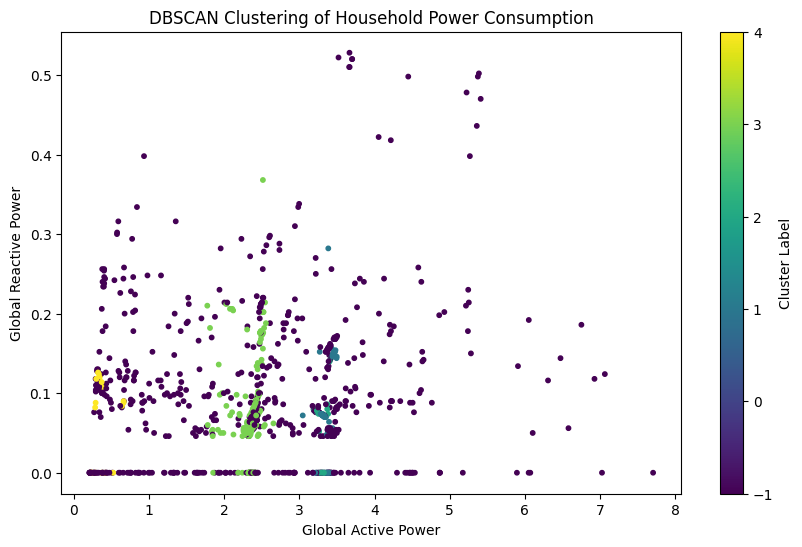

In [874]:
# 2. Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(household_df['Global_active_power'], household_df['Global_reactive_power'], c=labels, cmap='viridis', s=10)
plt.title('DBSCAN Clustering of Household Power Consumption')
plt.xlabel('Global Active Power')
plt.ylabel('Global Reactive Power')
plt.colorbar(label='Cluster Label')
plt.show()


In [875]:
# Silhouette score
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(household_df, labels)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: -0.19753463755255463
